In [32]:
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob 
import glob as gb
from PIL import Image
import tensorflow as tf
import imageio
import os
from tensorflow.keras import layers
import time
import pandas as pd
from IPython import display
import cv2
import pickle
import os.path

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Add after imports
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Add near the top of the notebook with other global variables
OUTPUT_DIR = '/kaggle/working/generated_images'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [33]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


In [34]:
trainpath = '/kaggle/input/anime-faces/'
image_size=28    
processed_data_path = '/kaggle/working/processed_images.pkl'

def process_and_save_images():
    X_train = []
    for folder in os.listdir(trainpath):
        files = gb.glob(pathname= str( trainpath +folder+ '/*.png'))
        print( 'numbers of images in folder are : ', len(files))
        print(' start reading images')
        for file in files: 
            orignal_image = cv2.imread(file)
            image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2GRAY)
            image = image / 255.0
            resized_image = cv2.resize(image , (image_size,image_size))
            X_train.append(resized_image)
        print('image reading ...finished')
        print("items in X_train is:       ",len(X_train) , " items") 
    
    # Convert to numpy array and reshape
    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    
    # Save processed data
    with open(processed_data_path, 'wb') as f:
        pickle.dump(X_train, f)
    
    return X_train

def load_or_process_images():
    if os.path.exists(processed_data_path):
        print("Loading preprocessed images...")
        with open(processed_data_path, 'rb') as f:
            X_train = pickle.load(f)
        print("Loaded", len(X_train), "preprocessed images")
    else:
        print("Processing images for the first time...")
        X_train = process_and_save_images()
    
    return X_train

# Replace the original image loading code with this:
X_train = load_or_process_images()

# Continue with the rest of your code
BUFFER_SIZE = 1000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Loading preprocessed images...
Loaded 21551 preprocessed images


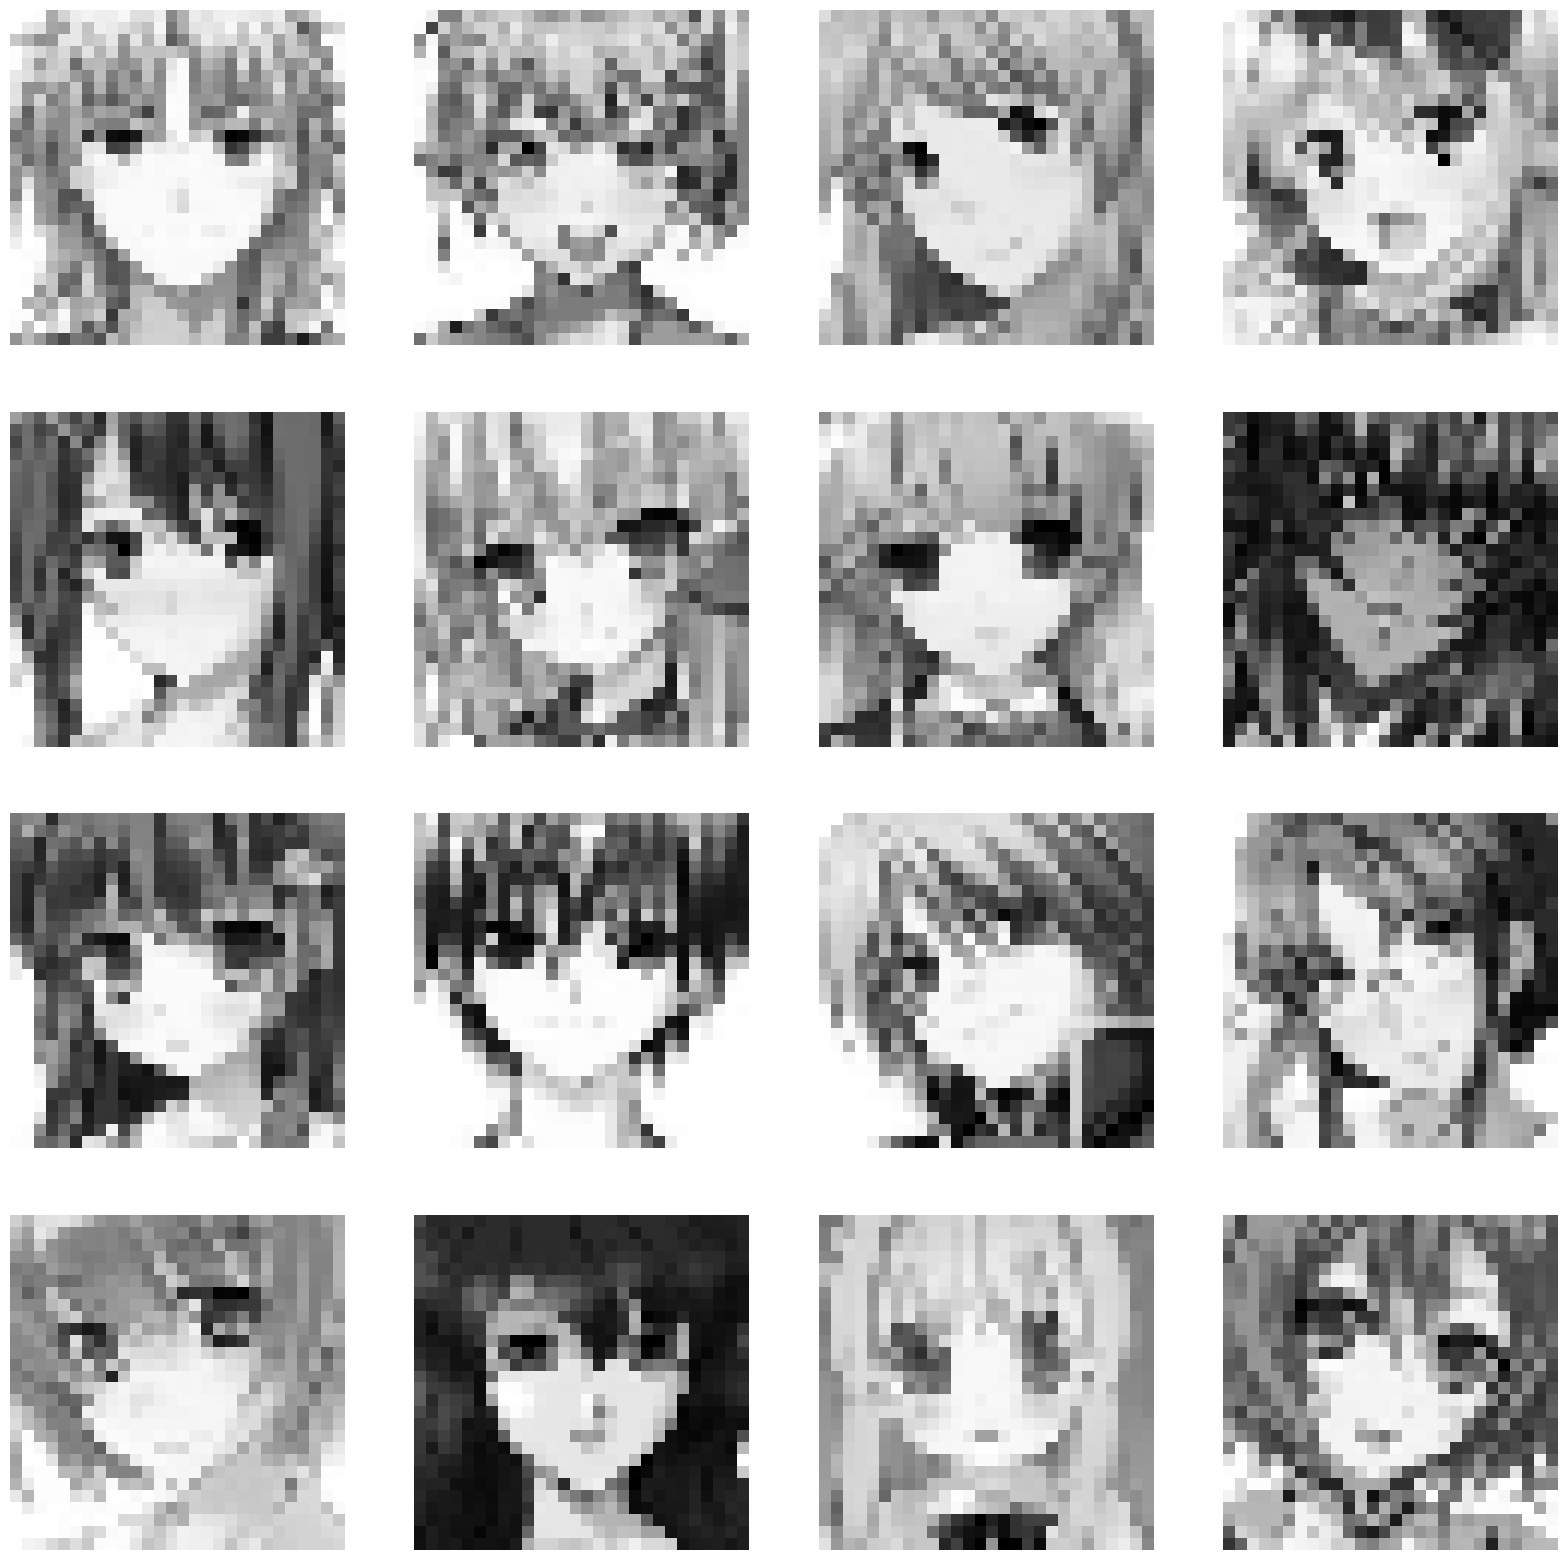

In [35]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train ),16))) : 
    plt.subplot(4,4,n+1)
    plt.imshow(X_train [i],cmap='gray')   
    plt.axis('off')

In [36]:
X_train = np.array(X_train)

In [37]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [38]:
BUFFER_SIZE = 1000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [39]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(28*28*4, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((image_size, image_size, 4)))
    assert model.output_shape == (None, image_size, image_size, 4)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, image_size, image_size, 1)

    return model

In [40]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 3136)                │         313,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3136)                │          12,544 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 64)          │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 28, 28, 32)          │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 1)           │             800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 384,928 (1.47 MB)

 Trainable params: 378,464 (1.44 MB)

 Non-trainable params: 6,464 (25.25 KB)

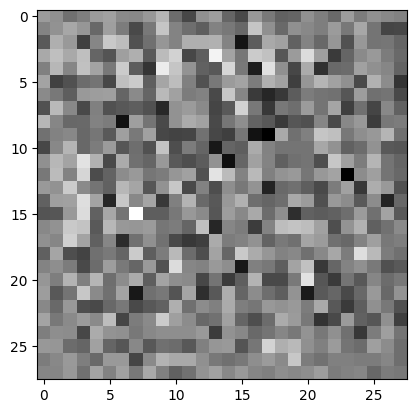

In [41]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray') 

In [42]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[image_size,image_size, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D(2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Dense(1,activation = 'sigmoid'))

    return model

In [43]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 272,385 (1.04 MB)

 Trainable params: 272,385 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.528]], shape=(1, 1), dtype=float16)


In [45]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # Changed from True since we use sigmoid

In [46]:
tensor = tf.constant([[1, 2, 3], [4, 5, 6]])
tf.ones_like(tensor)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [47]:
tensor = tf.constant([[1, 2, 3], [4, 5, 6]])
tf.zeros_like(tensor)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[0, 0, 0],
       [0, 0, 0]], dtype=int32)>

In [48]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [49]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [50]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [51]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [52]:
EPOCHS = 50
noise_dim = 100
BATCH_SIZE = 128

In [53]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,BATCH_SIZE):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss , disc_loss

In [54]:
num_examples_to_generate = 8
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 255.0, cmap='gray')
        plt.axis('off')

    # Save with full path
    save_path = os.path.join(OUTPUT_DIR, f'image_at_epoch_{epoch:04d}.png')
    plt.savefig(save_path)
    plt.close()  # Close the figure to free memory
    return save_path  # Return the path for reference

In [55]:
def train(dataset, epochs, BATCH_SIZE, patience=5):
    loss_gen = []
    loss_disc = []
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in tqdm(range(epochs)):
        L1, L2 = 0, 0
        start = time.time()
        num_batches = 0
        
        for image_batch in dataset:
            Ln1, Ln2 = train_step(image_batch, BATCH_SIZE)
            L1 += Ln1
            L2 += Ln2
            num_batches += 1
            
        # Average losses
        L1 = L1 / num_batches
        L2 = L2 / num_batches
        current_loss = L1 + L2
        
        loss_gen.append(L1)
        loss_disc.append(L2)
        
        # Early stopping check
        if current_loss < best_loss:
            best_loss = current_loss
            patience_counter = 0
            # Save best model
            checkpoint.save(file_prefix=checkpoint_prefix)
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
            
        # Clear output and generate images
        display.clear_output(wait=True)
        print(f'Epoch {epoch+1}, Gen Loss: {L1:.4f}, Disc Loss: {L2:.4f}')
        generate_and_save_images(generator, epoch + 1, seed)
        
        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')
    
    return loss_gen, loss_disc

In [56]:
def validate_dataset(dataset):
    try:
        for batch in dataset.take(1):
            if batch.shape[0] != BATCH_SIZE or batch.shape[3] != 1:
                print(f"Warning: Expected shape (BATCH_SIZE, 28, 28, 1), got {batch.shape}")
                return False
        return True
    except Exception as e:
        print(f"Dataset validation failed: {str(e)}")
        return False

# Add before training
if validate_dataset(train_dataset):
    print("Dataset validation successful, starting training...")
    History_gen, History_disc = train(dataset=train_dataset, epochs=EPOCHS, BATCH_SIZE=BATCH_SIZE)
else:
    print("Dataset validation failed, please check your data preprocessing")

Epoch 5, Gen Loss: 0.8535, Disc Loss: 1.2672


 10%|█         | 5/50 [00:19<02:30,  3.35s/it]

Time for epoch 5 is 3.15 sec


 10%|█         | 5/50 [00:21<03:15,  4.35s/it]

Early stopping triggered at epoch 6


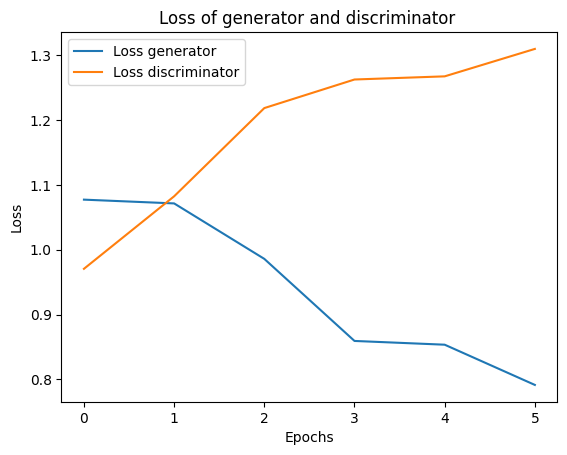

In [57]:
import matplotlib.pyplot as plt
plt.plot(range(len(History_gen)), History_gen, label='Loss generator')
plt.plot(range(len(History_disc)), History_disc, label='Loss discriminator')

plt.title('Loss of generator and discriminator ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [63]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def display_image(epoch):
    image_dir = '/kaggle/working/generated_images'
    ensure_dir(image_dir)
    
    image_path = os.path.join(image_dir, f'image_at_epoch_{epoch:04d}.png')
    
    try:
        if os.path.exists(image_path):
            return Image.open(image_path)
        else:
            print(f"Warning: Image file not found at {image_path}")
            return None
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

In [64]:
def show_latest_generation(epoch):
    img = display_image(epoch)
    if img is not None:
        plt.figure(figsize=(4, 4))
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.show()
    else:
        print("No image available to display")
show_latest_generation(EPOCHS)

No image available to display


In [65]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-t0b8z8c9
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-t0b8z8c9
  Resolved https://github.com/tensorflow/docs to commit bbc0b9c70fc0bd4411793d1b0bcc56ef1dbc2405
  Preparing metadata (setup.py) ... done


In [66]:
def create_animation():
    anim_file = os.path.join(OUTPUT_DIR, 'dcgan.gif')
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(os.path.join(OUTPUT_DIR, 'image_at_epoch_*.png'))
        filenames = sorted(filenames)
        if not filenames:
            print("No image files found to create animation")
            return None
        
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    return anim_file

In [68]:
from IPython.display import Image, display

<ipython-input-66-711125ce5159>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


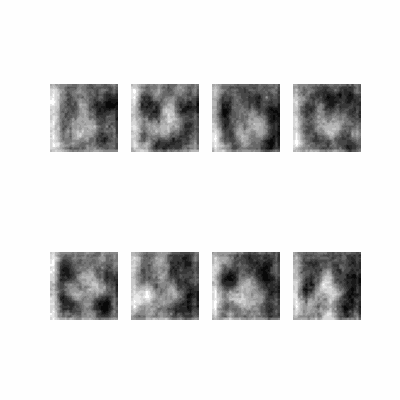

In [69]:
def show_animation(anim_file):
    if anim_file and os.path.exists(anim_file):
        display(Image(filename=anim_file))
    else:
        print("Animation file not found")
gif_file = create_animation()
show_animation(gif_file)